In [1]:
import os
from pathlib import Path
import numpy as np
from gammapy.datasets import Datasets, SpectrumDatasetOnOff
from gammapy.modeling.models import TemplateNDSpectralModel, PointSpatialModel, SkyModel, PowerLawNormSpectralModel, Models, SpectralModel
from gammapy.maps import Map
from gammapy.modeling import Fit, Sampler
from gammapy.modeling.models import UniformPrior, GaussianPrior
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

First let's read our files into memory

In [2]:
datasets = Datasets.read("datasets/datasets_joint_crab_1d.yaml")

instruments = ["fermi", "fact", "magic", "veritas", "hess", "hawc"] 

### Fitting the simple model

In [3]:
crab_position = SkyCoord(83.6324, 22.0174, unit="deg", frame="icrs")

spatial_model = PointSpatialModel.from_position(crab_position)
spatial_model.freeze() # frozen for 1D analysis


In [4]:
model = TemplateNDSpectralModel(Map.read("models/crab_pheno_IC.fits", format="gadf"))
model.alpha.value=-1.0
norm_model = PowerLawNormSpectralModel()

norm_model.norm.frozen=True
IC_model = SkyModel(spectral_model=model*norm_model, spatial_model=spatial_model, name="pheno_IC")

datasets.models = [IC_model]

The filename is not defined. Therefore, the model will not be serialised correctly. To set the filename, the "template_model.filename" attribute can be used.


In [5]:
fit_results = Fit().run(datasets)

HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


In [6]:
print(fit_results)
display(fit_results.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 28
	total stat : -770705.15

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,link,prior
str8,str1,str9,float64,str3,float64,float64,float64,bool,str1,str1
pheno_IC,,alpha,-5.0665e-01,,2.338e-02,-1.075e+00,0.000e+00,False,,
pheno_IC,,tilt,0.0000e+00,,0.000e+00,nan,nan,True,,
pheno_IC,,norm,1.0000e+00,,0.000e+00,nan,nan,True,,
pheno_IC,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,,
pheno_IC,,lon_0,8.3632e+01,deg,0.000e+00,nan,nan,True,,
pheno_IC,,lat_0,2.2017e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,,


### Introduce the biased version

Let's check the content looks OK

The filename is not defined. Therefore, the model will not be serialised correctly. To set the filename, the "template_model.filename" attribute can be used.


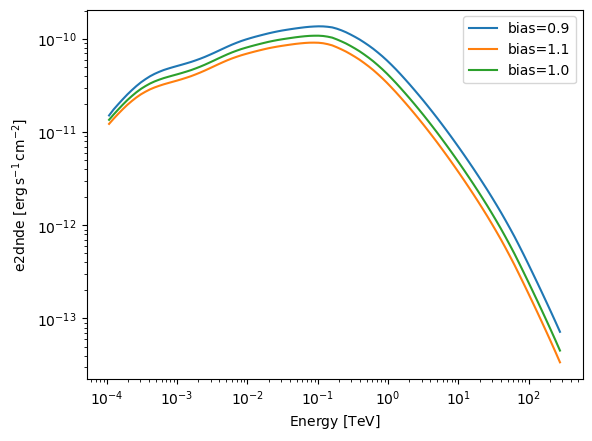

In [17]:
biased_IC_model = TemplateNDSpectralModel(Map.read("models/biased_crab_pheno_IC.fits", format="gadf"))
biased_IC_model.alpha.value=-1.0
biased_IC_model.bias.value=1.0

energies = np.geomspace(0.1,2e5)*u.GeV

ax = plt.gca()
for val in [0.9,1.1, 1.0]:
    biased_IC_model.bias.value=val
    biased_IC_model.plot(ax=ax, energy_bounds=[0.1*u.GeV, 300*u.TeV], sed_type="e2dnde", label=f"bias={val}")
ax.legend()

In [12]:
def get_instrument_datasets(datasets, instrument):
    return Datasets([d for d in datasets if instrument in d.name])

In [13]:
models = Models()

biased_IC_model.alpha.prior = UniformPrior(min=-1.0,max=0.)
biased_IC_model.bias.prior = GaussianPrior(mu=1.0,sigma=0.05)

for instrument in instruments:
    names = [_.name for _ in get_instrument_datasets(datasets, instrument)]
    spec_model = biased_IC_model.copy()
    models.append(SkyModel(spectral_model=spec_model, spatial_model=spatial_model, datasets_names=names, name=f"IC_{instrument}"))

for model in models[1:]:
    model.spectral_model.alpha = models[0].parameters["alpha"]

In [14]:
datasets.models = models
print(models)

Models

Component 0: SkyModel

  Name                      : IC_fermi
  Datasets names            : ['_fermi_obs0']
  Spectral model type       : TemplateNDSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    alpha@D13CRlOS                :     -1.000   +/-    0.00             
    bias                          :      1.000   +/-    0.00             
    lon_0@VCCfhqw1        (frozen):     83.632       deg         
    lat_0@s4aoAjEd        (frozen):     22.017       deg         

Component 1: SkyModel

  Name                      : IC_fact
  Datasets names            : ['_fact_stacked']
  Spectral model type       : TemplateNDSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    alpha@D13CRlOS                :     -1.000   +/-    0.00             
    bias                          :      1.000   +/-    0.00             
    lon_0@VCCfhqw1        (frozen):     83.632      

In [15]:
fit = Fit()
fit_results = fit.run(datasets)

/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/gammapy/maps/wcs/ndmap.py:952: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return scipy.signal.convolve(image, kernel, method=method, mode=mode)
/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/gammapy/maps/wcs/ndmap.py:952: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return scipy.signal.convolve(image, kernel, method=method, mode=mode)
/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/gammapy/maps/wcs/ndmap.py:952: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return scipy.signal.convolve(image, kernel, method=method, mode=mode)
/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python

In [18]:
print(fit_results)
display(fit_results.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 857
	total stat : -770750.15

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,link,prior
str10,str1,str5,float64,str3,float64,float64,float64,bool,str14,str13
IC_fermi,,alpha,-4.6811e-01,,5.004e-02,-1.075e+00,0.000e+00,False,alpha@dhFBXuFX,UniformPrior
IC_fermi,,bias,1.0102e+00,,1.525e-02,5.000e-01,1.500e+00,False,,GaussianPrior
IC_fermi,,lon_0,8.3632e+01,deg,0.000e+00,nan,nan,True,lon_0@7eZcZoi0,
IC_fermi,,lat_0,2.2017e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,lat_0@v_5IQpSw,
IC_fact,,alpha,-4.6811e-01,,5.004e-02,-1.075e+00,0.000e+00,False,alpha@dhFBXuFX,UniformPrior
IC_fact,,bias,1.0753e+00,,3.099e-02,5.000e-01,1.500e+00,False,,GaussianPrior
IC_fact,,lon_0,8.3632e+01,deg,0.000e+00,nan,nan,True,lon_0@7eZcZoi0,
IC_fact,,lat_0,2.2017e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,lat_0@v_5IQpSw,
IC_magic,,alpha,-4.6811e-01,,5.004e-02,-1.075e+00,0.000e+00,False,alpha@dhFBXuFX,UniformPrior


In [19]:
%%time
parameter = models[0].parameters["alpha"]

# Compute confidence interval for parameter alpha
res_1sig = fit.confidence(datasets, parameter=parameter)
res_2sig = fit.confidence(datasets, parameter=parameter, sigma=2)

# Compute profile likelihood of parameter alpha
parameter.scan_values = np.linspace(-1.,0.,50)
prof_results = fit.stat_profile(datasets, parameter=parameter, reoptimize=True)

/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/gammapy/maps/wcs/ndmap.py:952: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return scipy.signal.convolve(image, kernel, method=method, mode=mode)
/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/gammapy/maps/wcs/ndmap.py:952: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return scipy.signal.convolve(image, kernel, method=method, mode=mode)
/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/gammapy/maps/wcs/ndmap.py:952: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return scipy.signal.convolve(image, kernel, method=method, mode=mode)
/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python

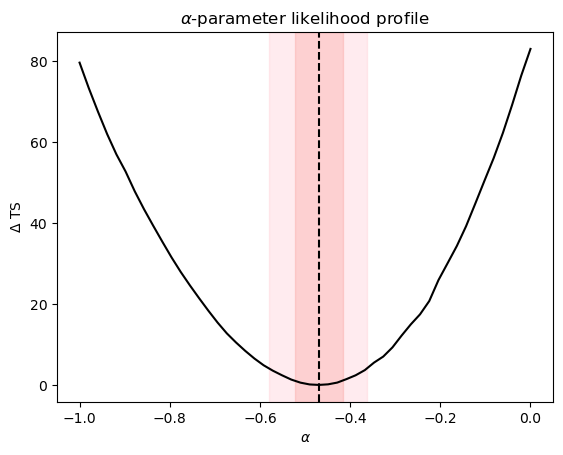

In [20]:
ax = plt.gca()
ax.plot(prof_results['IC_fermi.spectral.alpha_scan'], prof_results['stat_scan']-fit_results.total_stat, color='k')
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\rm \Delta\ TS$")

ax.set_title(r"$\alpha$-parameter likelihood profile")

ax.axvspan(   
    xmin=parameter.value - res_1sig["errn"],
    xmax=parameter.value + res_1sig["errp"],
    alpha=0.3, 
    color='salmon',
)

ax.axvspan(   
    xmin=parameter.value - res_2sig["errn"],
    xmax=parameter.value + res_2sig["errp"],
    alpha=0.3, 
    color='pink',
)

ax.axvline(parameter.value, color="k", linestyle='--')

AttributeError: 'MapDataset' object has no attribute 'plot_fit'

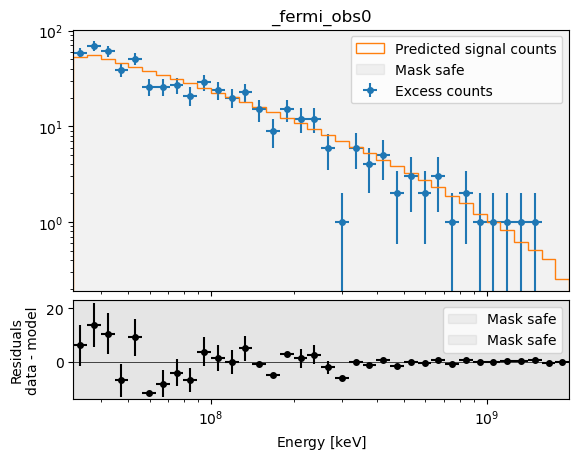

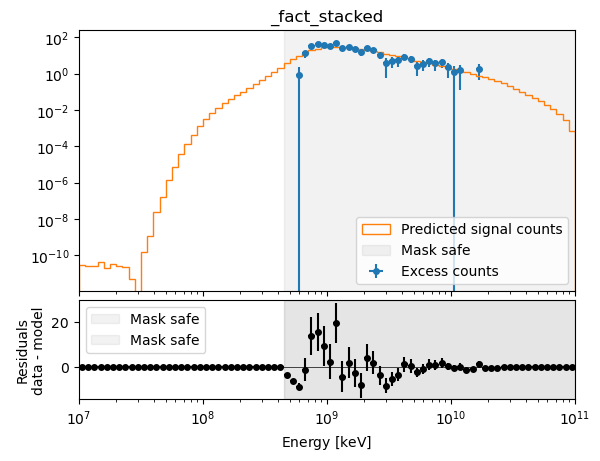

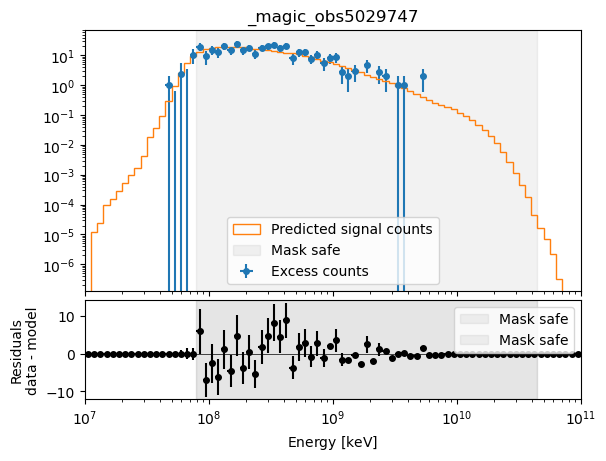

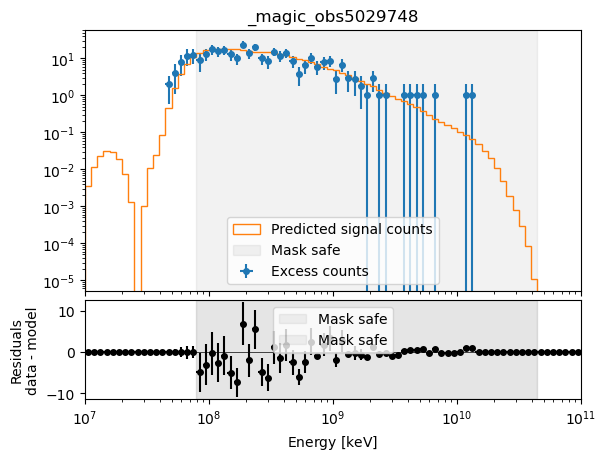

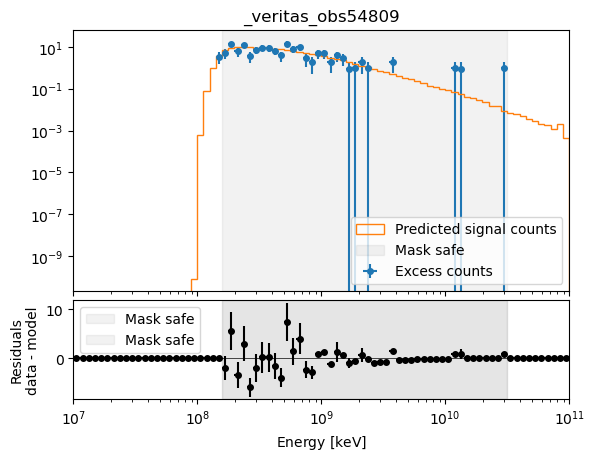

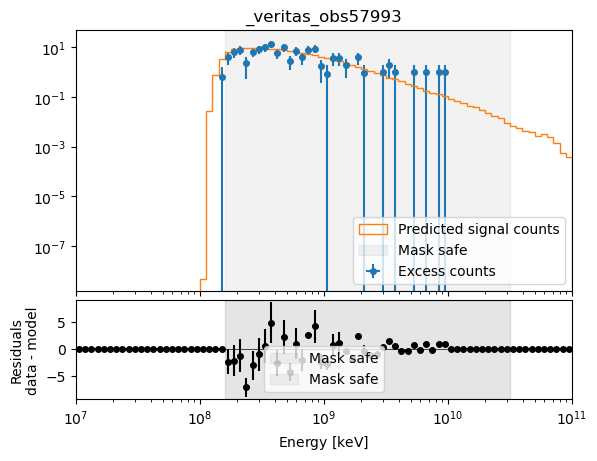

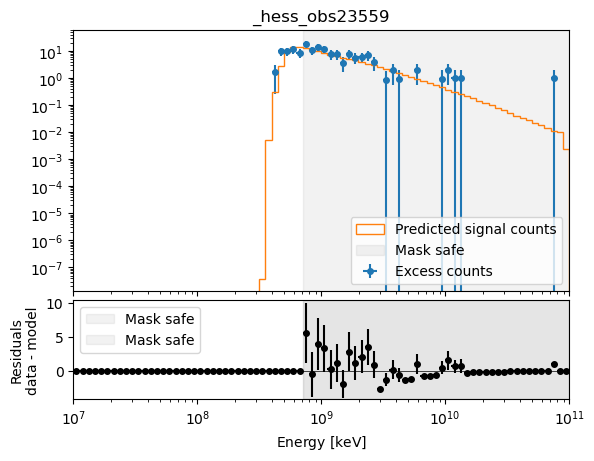

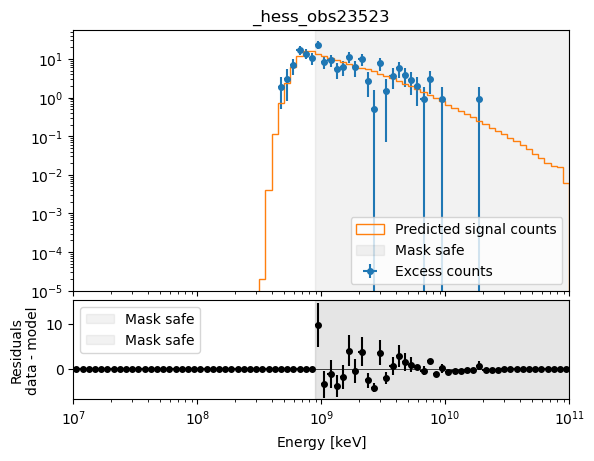

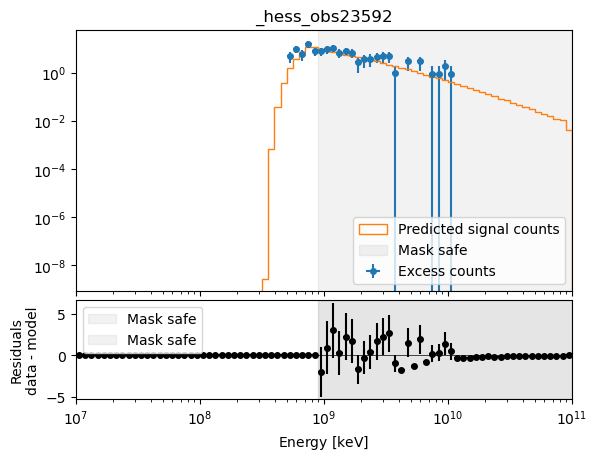

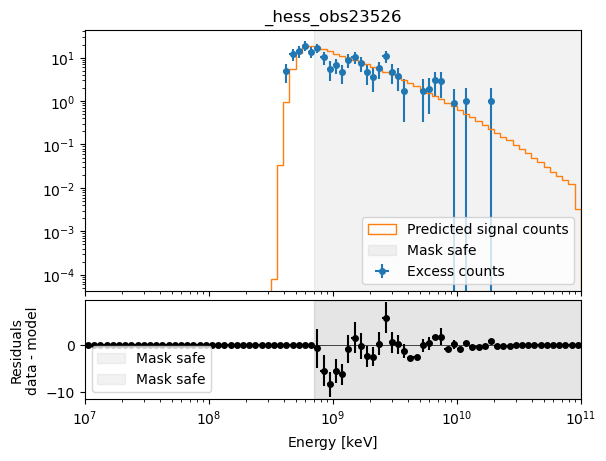

<Figure size 640x480 with 0 Axes>

In [21]:
for dataset in datasets:
    plt.figure()
    ax = dataset.plot_fit()
    ax[0].set_title(dataset.name)

In [22]:
%%time
sampler_opts = {
    "live_points": 300,
    "frac_remain": 0.3,
    "log_dir": None,
}

sampler = Sampler(backend="ultranest", sampler_opts=sampler_opts)
sample_results = sampler.run(datasets)

[ultranest] Sampling 300 live points from prior ...


[ultranest] Explored until L=4e+05  .385366.02 [385363.6229..385363.6238]*| it/evals=3073/21345 eff=14.5973% N=299 
[ultranest] Likelihood function evaluations: 21345
[ultranest]   logZ = 3.854e+05 +- 0.122
[ultranest] Effective samples strategy satisfied (ESS = 1212.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.29, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.26 total:0.29 required:<0.50
[ultranest] done iterating.

logZ = 385355.359 +- 0.421
  single instance: logZ = 385355.359 +- 0.149
  bootstrapped   : logZ = 385355.342 +- 0.328
  tail           : logZ = +- 0.263
insert order U test : converged: True correlation: inf iterations

    alpha               : -0.673│ ▁▁  ▁▁▁▁▁▁▁▁▂▃▃▄▄▄▆▆▇▆▇▇▇▆▅▆▄▂▃▂▂▁▁▁▁ │-0.322    -0.464 +- 0.049
    bias                : 0.939 │ ▁ ▁▁▁▁▁▂▂▃▃▅▆▇▇▇▇▇▆▆▇▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁ │1.104     1.015 +- 0.020
    bias 

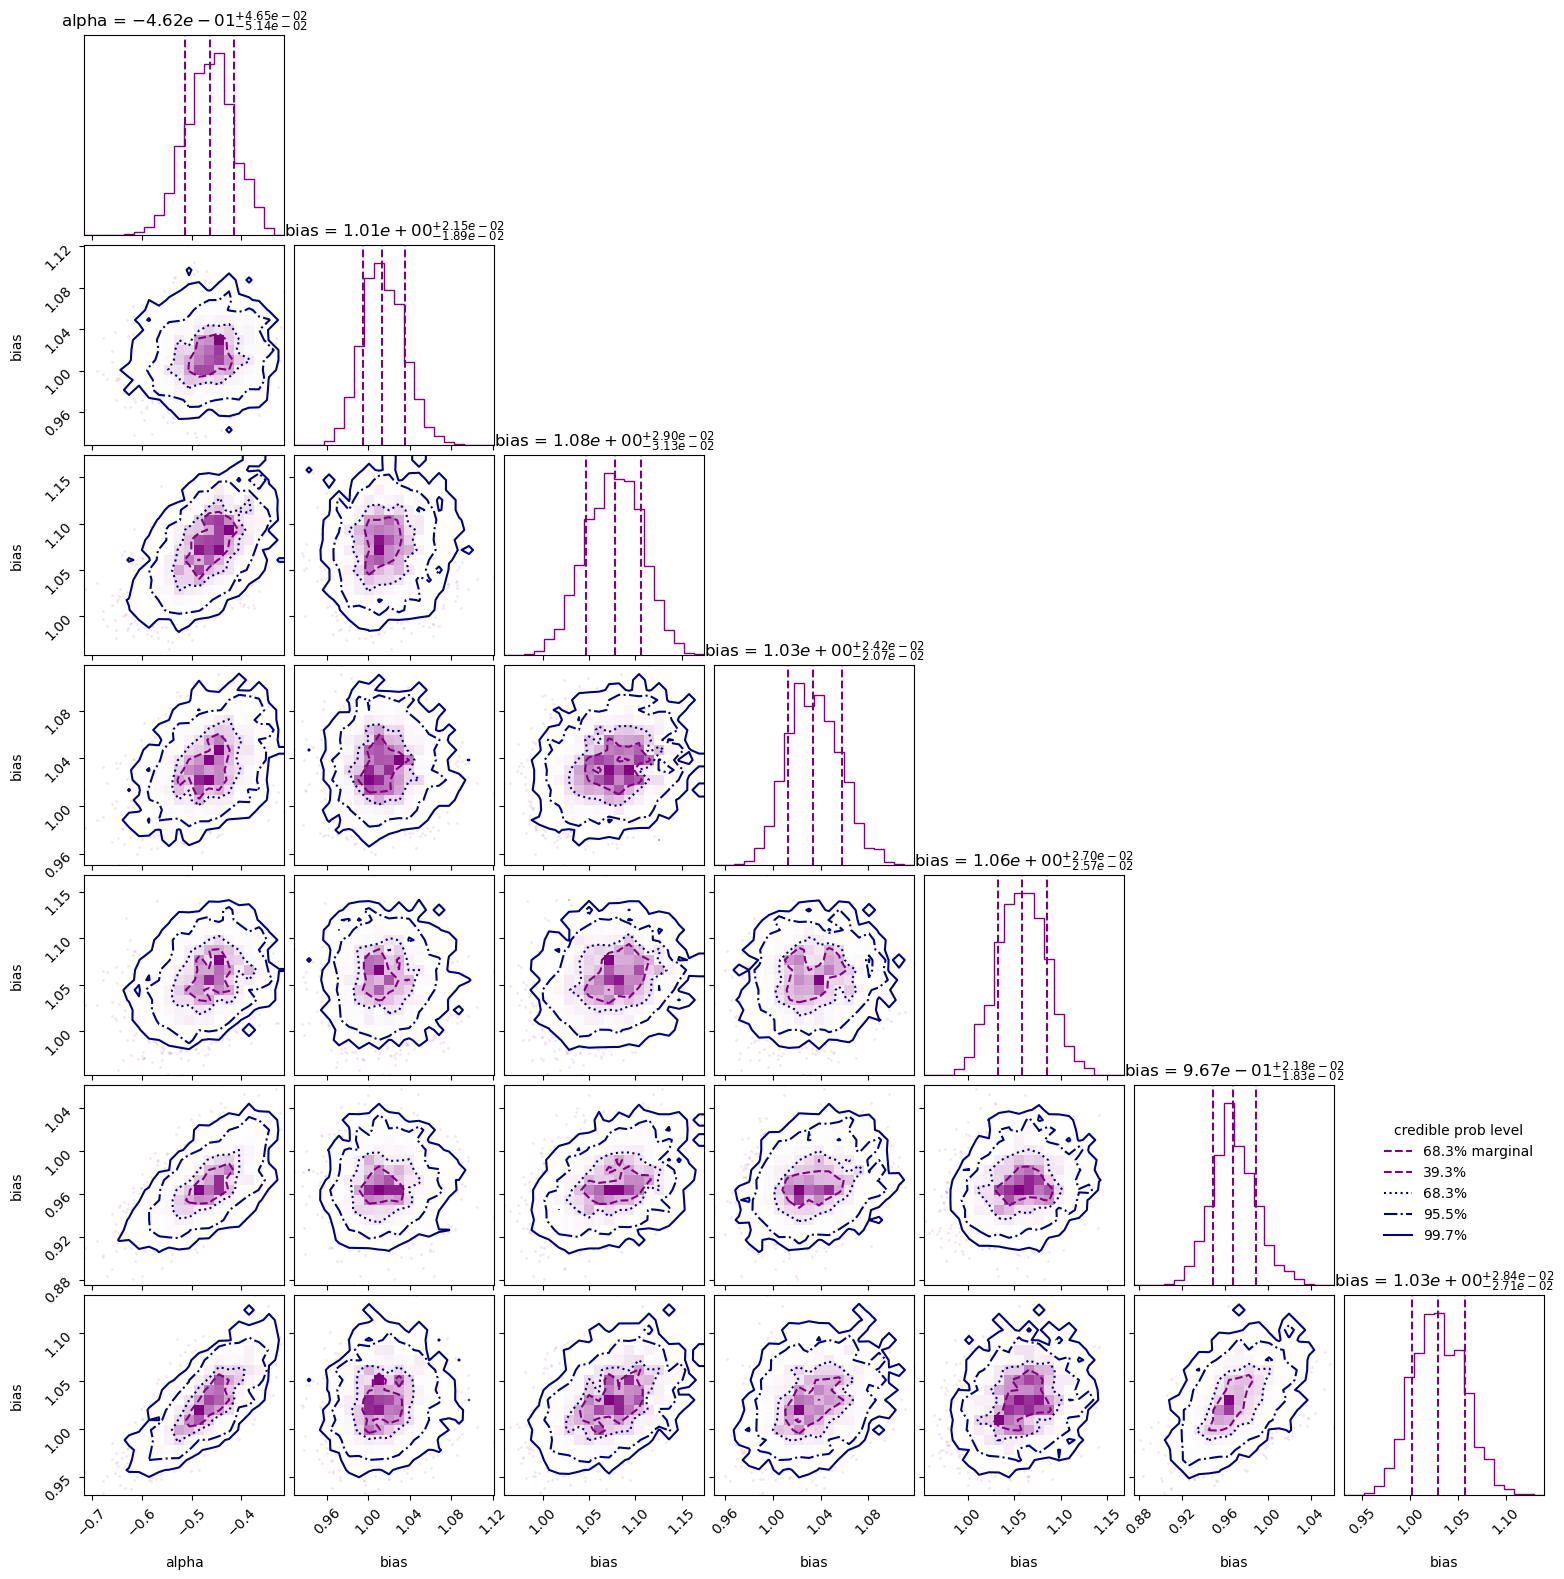

In [23]:
from ultranest.plot import cornerplot

cornerplot(
    sample_results.sampler_results,
    plot_datapoints=True,
    plot_density=True,
    bins=20,
    title_fmt=".2e",
    smooth=False,
)
plt.show()

In [46]:
from gammapy.estimators import FluxPointsEstimator

In [28]:
fp_edges = {
    "fermi" : np.geomspace(0.03, 1, 8)*u.TeV,
    "magic" : np.geomspace(0.08, 10, 8)*u.TeV,
    "fact" : np.geomspace(0.8, 10, 8)*u.TeV,
    "veritas" : np.geomspace(0.2, 20, 10)*u.TeV,
    "hess" : np.geomspace(0.5, 30, 8)*u.TeV,
    "hawc" : np.geomspace(1, 100, 8)*u.TeV,
}

In [29]:
fps=dict()

for instrument in instruments:
    fp = FluxPointsEstimator(energy_edges=fp_edges[instrument])
    fps[instrument] = fp.run(get_instrument_datasets(datasets, instrument))


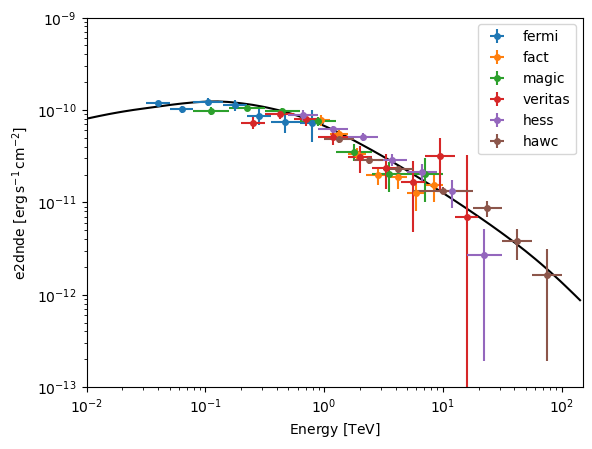

In [32]:
unbiased_model = datasets[0].models[0].copy()
unbiased_model.parameters["bias"].value = 1.0

ax = unbiased_model.spectral_model.plot(energy_bounds=[0.01, 150]*u.TeV, sed_type="e2dnde", color='k')

for instrument in instruments:
    ax = fps[instrument].plot(sed_type="e2dnde", ax=ax, label=instrument)

ax.set_xlim(1e-2, 150)
ax.set_ylim(1e-13, 1e-9)
ax.legend()